# Лабораторная работа 1: Регрессионный анализ

**Цель работы:** научиться применять модели линейной регрессии библиотеки scikit-learn к набору эмпирических данных

**Задание:** 
- Загрузить данные из файла lab1-09.csv
- Визуализировать данные
- Разбить на обучающую/тестовую выборки
- Обучить модель линейной регрессии
- Проверить качество модели
- Получить эмпирическую формулу

## 1. Импорт необходимых библиотек

In [33]:
# Импорт библиотек
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# Загрузить данные из файла
dataset = pd.read_csv('..\\..\\tasks\\lab1\\dataset\\lab1-09.csv', header=None)
dataset.head(5)

,0,1
0,7.575758,-5.944385
1,2.606061,-0.061360
2,0.636364,3.195567
3,4.484848,-1.589747
4,-0.424242,6.873144


## 2. Визуализация загруженных данных

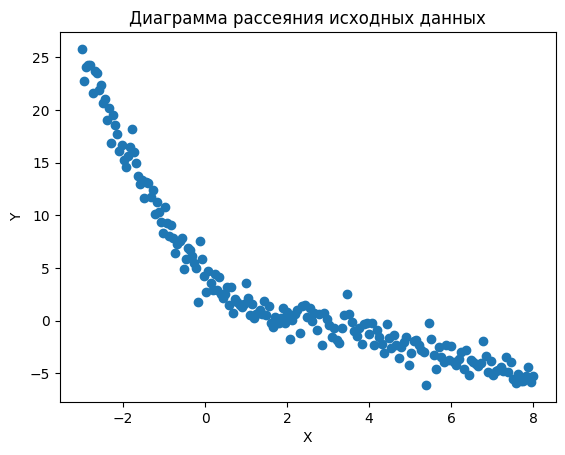

In [34]:
# Визуализировать загруженные данные (диаграмма рассеяния)
plt.scatter(dataset[0], dataset[1])
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Диаграмма рассеяния исходных данных')
plt.show()

## 3. Подготовка данных

In [35]:
# Разбить данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(dataset[0].to_frame(), dataset[1], test_size=0.2, random_state=42)

## 4. Выбор модели регрессии и её обучение

In [36]:
# Линейная регрессия (базовая модель)
model_regression = LinearRegression()
model_regression.fit(X_train, y_train)

LinearRegression()

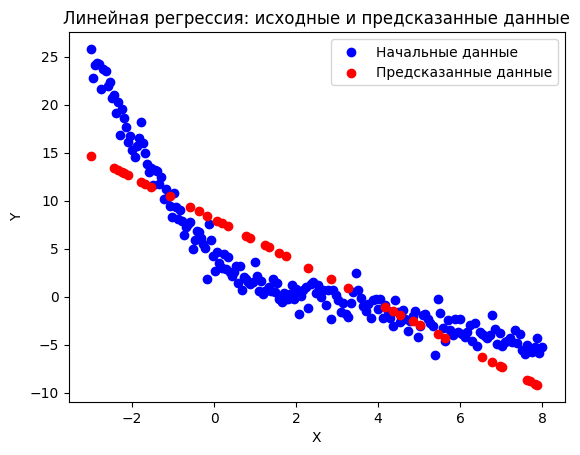

Метрика:          MSE            MAE
Train 12.72780916829956 2.8657105240378895
Test 19.004581108050964 3.7375051889679853

Вывод:
Как видно из диаграммы рассеяния, линейная регрессия плохо подходит для данного набора данных.
Значения MSE (12.73 / 19.00) и MAE (2.87 / 3.74)
достаточно высоки, что свидетельствует о значительных ошибках в предсказаниях модели,
что логично, ведь простая линейная регрессия пытается аппроксимировать кривую насыщения прямой линией.


In [37]:
# Проверить качество полученной модели на тестовых данных
# Визуализировать результат для линейной регрессии

train_predict_regression = model_regression.predict(X_train)
test_predict_regression = model_regression.predict(X_test)

plt.scatter(dataset[0], dataset[1], color='blue', label='Начальные данные')
plt.scatter(X_test, test_predict_regression, color='red', label='Предсказанные данные')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.title('Линейная регрессия: исходные и предсказанные данные')
plt.show()

# Расчет метрик
train_mse_regression = mean_squared_error(y_train, train_predict_regression)
train_mae_regression = mean_absolute_error(y_train, train_predict_regression)

test_mse_regression = mean_squared_error(y_test, test_predict_regression)
test_mae_regression = mean_absolute_error(y_test, test_predict_regression)

print('Метрика:          MSE            MAE')
print('Train', train_mse_regression, train_mae_regression)
print('Test', test_mse_regression, test_mae_regression)

print('\nВывод:')
print('Как видно из диаграммы рассеяния, линейная регрессия плохо подходит для данного набора данных.')
print(f'Значения MSE ({train_mse_regression:.2f} / {test_mse_regression:.2f}) и MAE ({train_mae_regression:.2f} / {test_mae_regression:.2f})')
print('достаточно высоки, что свидетельствует о значительных ошибках в предсказаниях модели,')
print('что логично, ведь простая линейная регрессия пытается аппроксимировать кривую насыщения прямой линией.')

## 5. Улучшение модели

In [38]:
# Улучшение модели
print('\nУлучшение модели')
print('Т. к. данные имеют зависимость в виде кривой насыщения, попробуем создать линейные признаки,')
print('чтобы линейная регрессия могла их использовать')

# Функция для создания признака exp(-k*x)
def exp_feature(x, k=1.0):
    return np.exp(-k * x)

pipeline = Pipeline([
    ("exp", FunctionTransformer(func=lambda X: exp_feature(X, k=1.0), validate=False)),
    ("linreg", LinearRegression())
])

# Настраиваем параметр k с помощью GridSearchCV
param_grid = {"exp__func": [lambda X, k=k: exp_feature(X, k) for k in np.linspace(0.01, 2, 200)]}
grid = GridSearchCV(pipeline, param_grid, scoring='neg_mean_squared_error', cv=5)
grid.fit(X_train, y_train)

# Получаем лучшую модель
best_model = grid.best_estimator_
print("Лучший параметр k подобран автоматически через GridSearchCV.")

best_idx = np.argmax(grid.cv_results_['mean_test_score'])
best_k = np.linspace(0.01, 2, 200)[best_idx]
print(f"Лучший параметр k = {best_k:.4f}")

# Извлекаем коэффициенты модели
A = best_model.named_steps["linreg"].intercept_
B = -best_model.named_steps["linreg"].coef_[0]
print("A =", A)
print("B =", B)
print(f"\nЭмпирическая формула: y = {A:.4f} - {B:.4f} * exp(-{best_k:.4f} * x)")


Улучшение модели
Т. к. данные имеют зависимость в виде кривой насыщения, попробуем создать линейные признаки,
чтобы линейная регрессия могла их использовать
Лучший параметр k подобран автоматически через GridSearchCV.
Лучший параметр k = 0.3900
A = -4.1070991144219295
B = -9.242855354309887

Эмпирическая формула: y = -4.1071 - -9.2429 * exp(-0.3900 * x)


## 6. Оценка улучшенной модели

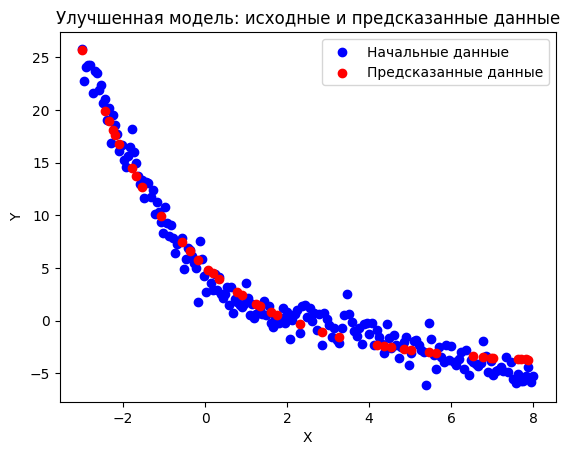

Метрика:          MSE            MAE
Train 1.45594282254409 0.9856079921124941
Test 1.8987996902987176 1.0786930903562326


In [39]:
# Оценка улучшенной модели
train_predict_regression = A - B * exp_feature(X_train, best_k)
test_predict_regression = A - B * exp_feature(X_test, best_k)

plt.scatter(dataset[0], dataset[1], color='blue', label='Начальные данные')
plt.scatter(X_test, test_predict_regression, color='red', label='Предсказанные данные')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.title('Улучшенная модель: исходные и предсказанные данные')
plt.show()

# Расчет метрик
train_mse_regression = mean_squared_error(y_train, train_predict_regression)
train_mae_regression = mean_absolute_error(y_train, train_predict_regression)

test_mse_regression = mean_squared_error(y_test, test_predict_regression)
test_mae_regression = mean_absolute_error(y_test, test_predict_regression)

print('Метрика:          MSE            MAE')
print('Train', train_mse_regression, train_mae_regression)
print('Test', test_mse_regression, test_mae_regression)

## Вывод:
Как видно из диаграммы рассеяния, этот подход лучше работает с предоставленными данными.
Ошибки уменьшились в несколько раз, что показывает значительное улучшение качества модели.
Учет экспоненциального признака и подбор оптимального параметра k позволяют построить
насыщающую кривую, которая гораздо точнее описывает данные.